# Import modules

In [1]:
from Model import *
from utilities import *
from sklearn.metrics import accuracy_score,confusion_matrix
from torch.optim import Adam
from torch.autograd import Variable
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np
import torch.utils.data as Data
import copy
import utils
import time
import torch
import torch.nn as nn
import pandas as pd
import math
import torch.nn.functional as F
import warnings
warnings.filterwarnings("ignore")

C:\Users\phoen\Anaconda3\envs\pytorch\lib\site-packages\tensorflow\python\framework\dtypes.py:516: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint8 = np.dtype([("qint8", np.int8, 1)])
C:\Users\phoen\Anaconda3\envs\pytorch\lib\site-packages\tensorflow\python\framework\dtypes.py:517: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_quint8 = np.dtype([("quint8", np.uint8, 1)])
C:\Users\phoen\Anaconda3\envs\pytorch\lib\site-packages\tensorflow\python\framework\dtypes.py:518: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint16 = np.dtype([("qint16", np.int16, 1)])
C:\Users\phoen\Anaconda3\envs\pytorch\lib\site-packages\tensorflow\

# Build the dataset

In [2]:
def get_dat(data_num):
    if data_num == 1:
        F_0 = np.load("./bearingset/data/T1_source_image.npy").transpose((0,3,1,2))/255
        F_1 = np.load("./bearingset/data/T1_target_image.npy").transpose((0,3,1,2))/255
        Y_0 = np.load("./bearingset/data/T1_source_label.npy")
        Y_1 = np.load("./bearingset/data/T1_target_label.npy")
        Label_Name =["1-OSF","2-OSP","3-ORF","4-ISF","6-IORF","7-IORP","8-H","Unknown"]
    if data_num == 2:
        F_0 = np.load("./bearingset/data/T2_source_image.npy").transpose((0,3,1,2))/255
        F_1 = np.load("./bearingset/data/T2_target_image.npy").transpose((0,3,1,2))/255
        Y_0 = np.load("./bearingset/data/T2_source_label.npy")
        Y_1 = np.load("./bearingset/data/T2_target_label.npy")
        Label_Name =["1-OSF","3-ORF","4-ISF","6-IORF","7-IORP","8-H","Unknown"]
    if data_num == 3:
        F_0 = np.load("./bearingset/data/T3_source_image.npy").transpose((0,3,1,2))/255
        F_1 = np.load("./bearingset/data/T3_target_image.npy").transpose((0,3,1,2))/255
        Y_0 = np.load("./bearingset/data/T3_source_label.npy")
        Y_1 = np.load("./bearingset/data/T3_target_label.npy")
        Label_Name =["1-OSF","2-OSP","3-ORF","4-ISF","5-IRF","Unknown"]
    if data_num == 4:
        F_0 = np.load("./bearingset/data/T4_source_image.npy").transpose((0,3,1,2))/255
        F_1 = np.load("./bearingset/data/T4_target_image.npy").transpose((0,3,1,2))/255
        Y_0 = np.load("./bearingset/data/T4_source_label.npy")
        Y_1 = np.load("./bearingset/data/T4_target_label.npy")
        Label_Name =["1-OSF","4-ISF","6-IORF","8-H","Unknown"]
    if data_num == 5:
        F_0 = np.load("./gearset/data/T1_source_image.npy").transpose((0,3,1,2))/255
        F_1 = np.load("./gearset/data/T1_target_image.npy").transpose((0,3,1,2))/255
        Y_0 = np.load("./gearset/data/T1_source_label.npy")
        Y_1 = np.load("./gearset/data/T1_target_label.npy")
        Label_Name =["1-N","3-BF&SI","4-G&E","Unknown"]
    if data_num == 6:
        F_0 = np.load("./gearset/data/T2_source_image.npy").transpose((0,3,1,2))/255
        F_1 = np.load("./gearset/data/T2_target_image.npy").transpose((0,3,1,2))/255
        Y_0 = np.load("./gearset/data/T2_source_label.npy")
        Y_1 = np.load("./gearset/data/T2_target_label.npy")
        Label_Name =["1-N","3-BF&SI","4-G&E","Unknown"]
    if data_num == 7:
        F_0 = np.load("./gearset/data/T3_source_image.npy").transpose((0,3,1,2))/255
        F_1 = np.load("./gearset/data/T3_target_image.npy").transpose((0,3,1,2))/255
        Y_0 = np.load("./gearset/data/T3_source_label.npy")
        Y_1 = np.load("./gearset/data/T3_target_label.npy")
        Label_Name =["1-N","3-BF&SI","4-G&E","Unknown"]
    F_0=torch.from_numpy(F_0.astype(np.float32))
    F_1=torch.from_numpy(F_1.astype(np.float32))
    Y_0=torch.from_numpy(Y_0.astype(np.float32))
    Y_1=torch.from_numpy(Y_1.astype(np.float32))
    data_0 = Data.TensorDataset(F_0,Y_0)
    data_1 = Data.TensorDataset(F_1,Y_1)
    return data_0,data_1,F_0,F_1,Y_0,Y_1,Label_Name
def Split(full_dataset):
    test_size = 200
    train_size = len(full_dataset) - test_size
    train_dataset, test_dataset = torch.utils.data.random_split(full_dataset, [train_size, test_size])
    return train_dataset, test_dataset

# Model building

## MMD Kernel defination

In [3]:
def guassian_kernel(source, target, kernel_mul=2.0, kernel_num=5, fix_sigma=None):
    n_samples = int(source.size()[0])+int(target.size()[0])
    total = torch.cat([source, target], dim=0)
    total0 = total.unsqueeze(0).expand(int(total.size(0)), int(total.size(0)), int(total.size(1)))
    total1 = total.unsqueeze(1).expand(int(total.size(0)), int(total.size(0)), int(total.size(1)))
    L2_distance = ((total0-total1)**2).sum(2)
    if fix_sigma:
        bandwidth = fix_sigma
    else:
        bandwidth = torch.sum(L2_distance.data) / (n_samples**2-n_samples)
    bandwidth /= kernel_mul ** (kernel_num // 2)
    bandwidth_list = [bandwidth * (kernel_mul**i) for i in range(kernel_num)]
    kernel_val = [torch.exp(-L2_distance / bandwidth_temp) for bandwidth_temp in bandwidth_list]
    return sum(kernel_val)#/len(kernel_val)

def mmd_rbf_accelerate(source, target, kernel_mul=2.0, kernel_num=5, fix_sigma=None):
    batch_size = int(source.size()[0])
    kernels = guassian_kernel(source, target,
        kernel_mul=kernel_mul, kernel_num=kernel_num, fix_sigma=fix_sigma)
    loss = 0
    for i in range(batch_size):
        s1, s2 = i, (i+1)%batch_size
        t1, t2 = s1+batch_size, s2+batch_size
        loss += kernels[s1, s2] + kernels[t1, t2]
        loss -= kernels[s1, t2] + kernels[s2, t1]
    return loss / float(batch_size)
def mmd_rbf_noaccelerate(source, target, kernel_mul=2.0, kernel_num=5, fix_sigma=None):
    batch_size = int(source.size()[0])
    kernels = guassian_kernel(source, target,
                              kernel_mul=kernel_mul, kernel_num=kernel_num, fix_sigma=fix_sigma)
    XX = kernels[:batch_size, :batch_size]
    YY = kernels[batch_size:, batch_size:]
    XY = kernels[:batch_size, batch_size:]
    YX = kernels[batch_size:, :batch_size]
    loss = torch.mean(XX + YY - XY -YX)
    return loss

## Feature extractor building

In [4]:
class CNN_Gear(nn.Module):

    def __init__(self):
        super(CNN_Gear, self).__init__()
        self.conv1 = nn.Sequential(
            nn.Conv2d(3,256, kernel_size=(4,4),stride=2,padding=1),
            nn.LeakyReLU(),
            nn.Dropout (p=0.5))
        self.conv2 = nn.Sequential(
            nn.Conv2d(256, 512,kernel_size=(3,3),stride=2,padding=1),
            nn.LeakyReLU())
            #nn.Dropout (p=0.25))
        self.conv3 = nn.Sequential(
            nn.Conv2d(512, 128, kernel_size=(3,3),stride=2, padding=1),
            nn.LeakyReLU())
            #nn.Dropout (p=0.25))
        self.conv4 = nn.Sequential(
            nn.Conv2d(128,64, kernel_size=(3,3),stride=2, padding=1),
            nn.LeakyReLU(),
            nn.Dropout (p=0.5))
        self.fc = nn.Sequential(
            nn.Linear(64*16, 1024))
        self.flatten= nn.Flatten()

    def forward(self, x):
        x_conv1 = self.conv1(x)
        x_conv1_feature = self.flatten(x_conv1)
        
        x_conv2 = self.conv2(x_conv1)
        x_conv2_feature = self.flatten(x_conv2)
        
        x_conv3 = self.conv3(x_conv2)
        x_conv3_feature = self.flatten(x_conv3)
        
        x_conv4 = self.conv4(x_conv3)
        x_conv4_feature = self.flatten(x_conv4)
        
        x_conv4 = x_conv4.view(x_conv4.size(0), 64*16)
        x_main = self.fc(x_conv4)
        
        return x_main,x_conv3_feature,x_conv4_feature
        
class CNN_Bearing(nn.Module):

    def __init__(self):
        super(CNN_Bearing, self).__init__()
        self.conv1 = nn.Sequential(
            nn.Conv2d(3,128, kernel_size=(3,3), padding=0),
            nn.ReLU(inplace=True))
            #nn.Dropout (p=0.25))
        self.conv2 = nn.Sequential(
            nn.Conv2d(128, 64, kernel_size=(3,3), padding=0),
            nn.ReLU(inplace=True))
            #nn.Dropout (p=0.25))
        self.conv3 = nn.Sequential(
            nn.Conv2d(64, 32, kernel_size=(3,3), padding=0),
            nn.ReLU(inplace=True))
            #nn.Dropout (p=0.25))
        self.conv4 = nn.Sequential(
            nn.Conv2d(32, 32, kernel_size=(3,3), padding=0),
            nn.ReLU(inplace=True))
            #nn.Dropout (p=0.25))
        self.conv5 = nn.Sequential(
            nn.Conv2d(32, 16, kernel_size=(3,3), padding=0),
            nn.ReLU(inplace=True),
            nn.Dropout (p=0.5))
        self.fc = nn.Sequential(
            nn.Linear(16 *2916, 1024))
        self.flatten= nn.Flatten()

    def forward(self, x):
        x_conv1 = self.conv1(x)
        x_conv1_feature = self.flatten(x_conv1)
        
        x_conv2 = self.conv2(x_conv1)
        x_conv2_feature = self.flatten(x_conv2)
        
        x_conv3 = self.conv3(x_conv2)
        x_conv3_feature = self.flatten(x_conv3)
        
        x_conv4 = self.conv4(x_conv3)
        x_conv4_feature = self.flatten(x_conv4)
        
        x_conv5 = self.conv5(x_conv4)
        x_conv5 = x_conv5.view(x_conv5.size(0), 16*2916)
        
        x_main = self.fc(x_conv5)

        return x_main,x_conv3_feature,x_conv4_feature
class FTNN(nn.Module):
    def __init__(self,class_num):
        super(FTNN, self).__init__()
        self.sharedNet = CNN_Bearing()
        self.fc1 = nn.Linear(1024,128)
        self.cls_fc = nn.Linear(128,class_num)
        self.soft = nn.Softmax(dim=-1)

    def forward(self, source, target):
        loss = 0
        loss1 = 0
        loss2 = 0
        source,source_1,source_2 = self.sharedNet(source)  
        if self.training == True:
            target,target_1,target_2 = self.sharedNet(target)      
            loss += mmd_rbf_noaccelerate(source, target)
            loss1 += mmd_rbf_noaccelerate(source_1, target_1)
            loss2 += mmd_rbf_noaccelerate(source_2, target_2)
        source_cls = self.fc1(source)   
        source_cls = self.cls_fc(source_cls)
        source_cls = self.soft(source_cls)
        return source_cls,loss,loss1,loss2

## Model training defination 

In [5]:
def train(model):
    src_iter = iter(src_train_loader)
    tgt_iter = iter(tgt_train_loader)
    correct = 0
    best_model_wts=copy.deepcopy(model.state_dict())
    final_model_wts=copy.deepcopy(model.state_dict())
    for i in range(1, iteration+1):
        model.train()
        LEARNING_RATE = lr / math.pow((1 + 10 * (i - 1) / (iteration)), 0.75)
        if (i-1)%100==0:
            print('learning rate{: .4f}'.format(LEARNING_RATE) )
        optimizer = torch.optim.Adam([
        {'params': model.sharedNet.parameters()},
        {'params': model.cls_fc.parameters()},{'params': model.fc1.parameters()},{'params': model.soft.parameters()}
        ], lr=LEARNING_RATE / 10, weight_decay=l2_decay)
        try:
            src_data, src_label = src_iter.next()
        except Exception as err:
            src_iter=iter(src_train_loader)
            src_data, src_label = src_iter.next()
            
        try:
            tgt_data, _ = tgt_iter.next()
        except Exception as err:
            tgt_iter=iter(tgt_train_loader)
            tgt_data, _ = tgt_iter.next()
            
        if cuda:
            src_data, src_label = src_data.cuda(), src_label.cuda()
            tgt_data = tgt_data.cuda()
        optimizer.zero_grad()
        src_pred, mmd_loss1,mmd_loss2,mmd_loss3 = model(src_data, tgt_data)
        cls_loss = CrossEntropyLoss(src_label.cuda(), src_pred.cuda())
        mmd_loss = mmd_loss1+mmd_loss2+mmd_loss3
        lambd = 1/ (1 + math.exp(-10 * (i) / iteration)) - 1
        loss = cls_loss + lambd * (mmd_loss)
        loss.backward()
        optimizer.step()
    return model

## Model testing definaiton

In [6]:
def test(model):
    model.eval()
    test_loss = 0
    correct = 0
    with torch.no_grad():
        for tgt_test_data, tgt_test_label in tgt_test_loader:
            if cuda:
                tgt_test_data, tgt_test_label = tgt_test_data.cuda(), tgt_test_label.cuda()
                tgt_test_data, tgt_test_label = Variable(tgt_test_data), Variable(tgt_test_label)
                tgt_pred, mmd_loss1,mmd_loss2,mmd_loss3 = model(tgt_test_data, tgt_test_data)
                test_loss += CrossEntropyLoss(tgt_test_label.cuda(), tgt_pred.cuda()).item() # sum up batch loss
                pred = tgt_pred.data.max(1)[1] # get the index of the max log-probability
                correct += pred.eq(tgt_test_label.data.max(1)[1].view_as(pred)).cpu().sum()

    test_loss /= tgt_dataset_len
    print('\n{} set: Average loss: {:.4f}, Accuracy: {}/{} ({:.2f}%)\n'.format(
        tgt_name, test_loss, correct, tgt_dataset_len,
        100. * correct / tgt_dataset_len))
    return correct

# Model training

In [7]:
task_num = 1

iteration=500
lr = 4e-4
momentum = 0.9
no_cuda =False
seed = 8
log_interval = 10
l2_decay = 8e-4
data_0,data_1,F_0,F_1,Y_0,Y_1,Label_Name = get_dat(task_num)
Train_0,Test_0 = Split(data_0)
Train_1,Test_1 = Split(data_1)
src_train_loader=Data.DataLoader(dataset=Train_0,batch_size=10,shuffle=True,num_workers=0)
tgt_train_loader=Data.DataLoader(dataset=Train_1,batch_size=10,shuffle=True,num_workers=0)
src_test_loader=Data.DataLoader(dataset=Test_0,batch_size=10,shuffle=True,num_workers=0)
tgt_test_loader=Data.DataLoader(dataset=Test_1,batch_size=10,shuffle=True,num_workers=0)
model = FTNN(class_num=Y_0.shape[1])
print(model)
src_dataset_len = len(src_train_loader.dataset)
tgt_dataset_len = len(tgt_test_loader.dataset)
src_loader_len = len(src_train_loader)
tgt_loader_len = len(tgt_train_loader)
src_name = "a"
tgt_name = "b"
no_cuda =False
cuda = not no_cuda and torch.cuda.is_available()
if cuda:
    model.cuda()
my_net=train(model)

FTNN(
  (sharedNet): CNN_Bearing(
    (conv1): Sequential(
      (0): Conv2d(3, 128, kernel_size=(3, 3), stride=(1, 1))
      (1): ReLU(inplace=True)
    )
    (conv2): Sequential(
      (0): Conv2d(128, 64, kernel_size=(3, 3), stride=(1, 1))
      (1): ReLU(inplace=True)
    )
    (conv3): Sequential(
      (0): Conv2d(64, 32, kernel_size=(3, 3), stride=(1, 1))
      (1): ReLU(inplace=True)
    )
    (conv4): Sequential(
      (0): Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1))
      (1): ReLU(inplace=True)
    )
    (conv5): Sequential(
      (0): Conv2d(32, 16, kernel_size=(3, 3), stride=(1, 1))
      (1): ReLU(inplace=True)
      (2): Dropout(p=0.5, inplace=False)
    )
    (fc): Sequential(
      (0): Linear(in_features=46656, out_features=1024, bias=True)
    )
    (flatten): Flatten(start_dim=1, end_dim=-1)
  )
  (fc1): Linear(in_features=1024, out_features=128, bias=True)
  (cls_fc): Linear(in_features=128, out_features=8, bias=True)
  (soft): Softmax(dim=-1)
)
learning rate

# Performance visualization

## The confusion matrix 

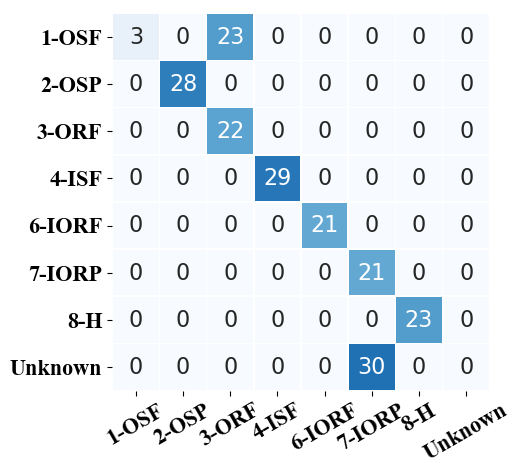

In [8]:
my_net = model.cuda()
True_label = []
Pred_Label = []

for (i, (im, label)) in enumerate(tgt_test_loader):

    predict_prob,_,_,_ = my_net.forward(im.cuda(),im.cuda())
    
    label = np.argmax(label, axis=-1).reshape(-1, 1)
    predict_index = np.argmax(predict_prob.cpu().detach().numpy(), axis=-1).reshape(-1, 1)
    
    True_label.append(np.array(label.flatten()))
    Pred_Label.append(np.array(predict_index.flatten()))
y_true = np.array(True_label).reshape((200,))
y_pred = np.array(Pred_Label).reshape((200,))

m = confusion_matrix(y_true,y_pred)
f, ax = plt.subplots(figsize=(5,5),dpi=100)

ax= sns.heatmap(m,vmin=0, vmax=40,cmap='Blues',annot=True,fmt='',linewidths=.5,square=True,cbar=None,annot_kws={"size":16})
plt.xticks(fontsize= 16, fontfamily= "Times New Roman")                      
plt.yticks(fontsize= 16, fontfamily= "Times New Roman") 
plt.margins(0, 0)
ax.set_xticklabels(Label_Name,rotation=30)
ax.set_yticklabels(Label_Name,rotation=0)

plt.margins(0, 0)

## The accuracy

In [9]:
pred_y = []
true_y = []
NUM_CLASSES = Y_1.shape[1]
with torch.no_grad():
    for tgt_test_data, tgt_test_label in tgt_test_loader:
        if cuda:
            tgt_test_data, tgt_test_label = tgt_test_data.cuda(), tgt_test_label.cuda()
            tgt_test_data, tgt_test_label = Variable(tgt_test_data), Variable(tgt_test_label)
            tgt_pred, mmd_loss1,mmd_loss2,mmd_loss3 = model(tgt_test_data, tgt_test_data)
            pred = tgt_pred.max(1, keepdim=True)[1] 
        for i in range(len(pred)):
            pred_y.append(pred[i].item())
            true_y.append(torch.argmax(tgt_test_label[i]).item())
a,b = utils.cal_acc(true_y, pred_y, NUM_CLASSES)
print("The accuracy on all the known classes: "+str(a))
print("The accuracy on all the target classes: "+str(b))

The accuracy on all the known classes: 0.73
The accuracy on all the target classes: 0.8588235294117647


# Model saving 

In [10]:
torch.save(model.state_dict(), './models/Compared_Methods_FTNN.pkl')